# Análise de Clusters com DBSCAN
Este notebook realiza a análise de agrupamento dos dados de saúde mental utilizando o algoritmo DBSCAN.

## 1. Importar Bibliotecas Necessárias

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.cluster import DBSCAN

## 2. Carregar Dados de Saúde Preparados

In [2]:
# Carregar dados preparados
data = pd.read_csv('./data/prepared_data.csv')
data.head()

,Survey_Date,Age,Gender,Region,Industry,Job_Role,Work_Arrangement,Hours_Per_Week,Mental_Health_Status,Burnout_Level,Work_Life_Balance_Score,Social_Isolation_Score,Salary_Range,Physical_Health_Shoulder_Pain,Physical_Health_Neck_Pain,Physical_Health_Back_Pain,Physical_Health_Eye_Strain,Physical_Health_Wrist_Pain
0,2025-06-01,27,Female,Asia,Professional Services,Data Analyst,Onsite,64,Stress Disorder,High,3,2,$40K-60K,1,0,0,0,0
1,2025-06-01,37,Female,Asia,Professional Services,Data Analyst,Onsite,37,Stress Disorder,High,4,2,$80K-100K,0,0,1,0,0
2,2025-06-01,32,Female,Africa,Education,Business Analyst,Onsite,36,ADHD,High,3,2,$80K-100K,1,0,0,0,0
3,2025-06-01,40,Female,Europe,Education,Data Analyst,Onsite,63,ADHD,Medium,1,2,$60K-80K,1,0,0,0,0
4,2025-06-01,52,Male,Oceania,Customer Service,Business Analyst,Onsite,61,Burnout,Medium,4,3,$60K-80K,0,0,1,0,0


## 3. Pré-processamento: OneHotEncoder e Normalização

In [3]:
# OneHotEncoder para variáveis categóricas
categorical_cols = data.select_dtypes(include=['object', 'category']).columns
encoder = OneHotEncoder(sparse_output=False, drop=None)
encoded = encoder.fit_transform(data[categorical_cols])
encoded_df = pd.DataFrame(encoded, columns=encoder.get_feature_names_out(categorical_cols), index=data.index)

# Concatenar com colunas numéricas
data_dbscan = pd.concat([data.drop(columns=categorical_cols), encoded_df], axis=1)

# Normalizar todas as variáveis
scaler = MinMaxScaler()
data_dbscan = pd.DataFrame(scaler.fit_transform(data_dbscan), columns=data_dbscan.columns, index=data_dbscan.index)
data_dbscan.head()

,Age,Hours_Per_Week,Work_Life_Balance_Score,Social_Isolation_Score,Physical_Health_Shoulder_Pain,Physical_Health_Neck_Pain,Physical_Health_Back_Pain,Physical_Health_Eye_Strain,Physical_Health_Wrist_Pain,Survey_Date_2025-06-01,...,Mental_Health_Status_Stress Disorder,Mental_Health_Status_unknown,Burnout_Level_High,Burnout_Level_Low,Burnout_Level_Medium,Salary_Range_$100K-120K,Salary_Range_$120K+,Salary_Range_$40K-60K,Salary_Range_$60K-80K,Salary_Range_$80K-100K
0,0.116279,0.966667,0.50,0.25,1.0,0.0,0.0,0.0,0.0,1.0,...,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1,0.348837,0.066667,0.75,0.25,0.0,0.0,1.0,0.0,0.0,1.0,...,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,0.232558,0.033333,0.50,0.25,1.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,0.418605,0.933333,0.00,0.25,1.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
4,0.697674,0.866667,0.75,0.50,0.0,0.0,1.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0


## 4. Rodar o DBSCAN

In [11]:
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score
import pandas as pd
import numpy as np

# Faixas de valores a testar
eps_values = np.arange(0.2, 2.0, 0.2)
min_samples_values = [2, 3, 5]

melhor_config = None
melhor_n_clusters = 0
melhor_labels = None

print("Teste de hiperparâmetros DBSCAN:")
print("-" * 50)

for eps in eps_values:
    for min_samples in min_samples_values:
        dbscan = DBSCAN(eps=eps, min_samples=min_samples)
        labels = dbscan.fit_predict(data_dbscan)
        
        n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
        n_ruido = list(labels).count(-1)
        
        print(f"eps={eps:.2f}, min_samples={min_samples} → clusters: {n_clusters}, ruído: {n_ruido}")
        
        if n_clusters > melhor_n_clusters:
            melhor_n_clusters = n_clusters
            melhor_config = (eps, min_samples)
            melhor_labels = labels

# Atribui a melhor configuração ao DataFrame original
if melhor_config is not None:
    data['dbscan_cluster'] = melhor_labels
    print("\n✅ Melhor configuração encontrada:")
    print(f"eps = {melhor_config[0]}, min_samples = {melhor_config[1]}")
    print(f"Clusters formados (excluindo ruído): {melhor_n_clusters}")
    print("Distribuição dos rótulos:")
    print(pd.Series(melhor_labels).value_counts())
else:
    print("\n❌ Nenhuma configuração gerou clusters válidos.")
    print("→ Tente aumentar o valor de `eps` ou reduzir `min_samples`.")


Teste de hiperparâmetros DBSCAN:
--------------------------------------------------
eps=0.20, min_samples=2 → clusters: 0, ruído: 2877
eps=0.20, min_samples=3 → clusters: 0, ruído: 2877
eps=0.20, min_samples=5 → clusters: 0, ruído: 2877
eps=0.40, min_samples=2 → clusters: 0, ruído: 2877
eps=0.40, min_samples=3 → clusters: 0, ruído: 2877
eps=0.40, min_samples=5 → clusters: 0, ruído: 2877
eps=0.60, min_samples=2 → clusters: 0, ruído: 2877
eps=0.60, min_samples=3 → clusters: 0, ruído: 2877
eps=0.60, min_samples=5 → clusters: 0, ruído: 2877
eps=0.80, min_samples=2 → clusters: 0, ruído: 2877
eps=0.80, min_samples=3 → clusters: 0, ruído: 2877
eps=0.80, min_samples=5 → clusters: 0, ruído: 2877
eps=1.00, min_samples=2 → clusters: 0, ruído: 2877
eps=1.00, min_samples=3 → clusters: 0, ruído: 2877
eps=1.00, min_samples=5 → clusters: 0, ruído: 2877
eps=1.20, min_samples=2 → clusters: 0, ruído: 2877
eps=1.20, min_samples=3 → clusters: 0, ruído: 2877
eps=1.20, min_samples=5 → clusters: 0, ruído: 287

## 5. Visualizar os Clusters com PCA

/Users/75467/Desktop/Doutorado/AAED/Trabalho_Final/MentalHealthAnalysis/.venv/lib/python3.12/site-packages/sklearn/decomposition/_pca.py:604: RuntimeWarning: divide by zero encountered in matmul
  C = X.T @ X
/Users/75467/Desktop/Doutorado/AAED/Trabalho_Final/MentalHealthAnalysis/.venv/lib/python3.12/site-packages/sklearn/decomposition/_pca.py:604: RuntimeWarning: overflow encountered in matmul
  C = X.T @ X
/Users/75467/Desktop/Doutorado/AAED/Trabalho_Final/MentalHealthAnalysis/.venv/lib/python3.12/site-packages/sklearn/decomposition/_pca.py:604: RuntimeWarning: invalid value encountered in matmul
  C = X.T @ X
/Users/75467/Desktop/Doutorado/AAED/Trabalho_Final/MentalHealthAnalysis/.venv/lib/python3.12/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/Users/75467/Desktop/Doutorado/AAED/Trabalho_Final/MentalHealthAnalysis/.venv/lib/python3.12/site-packages/sklearn/decomposition/_base.py:148: 

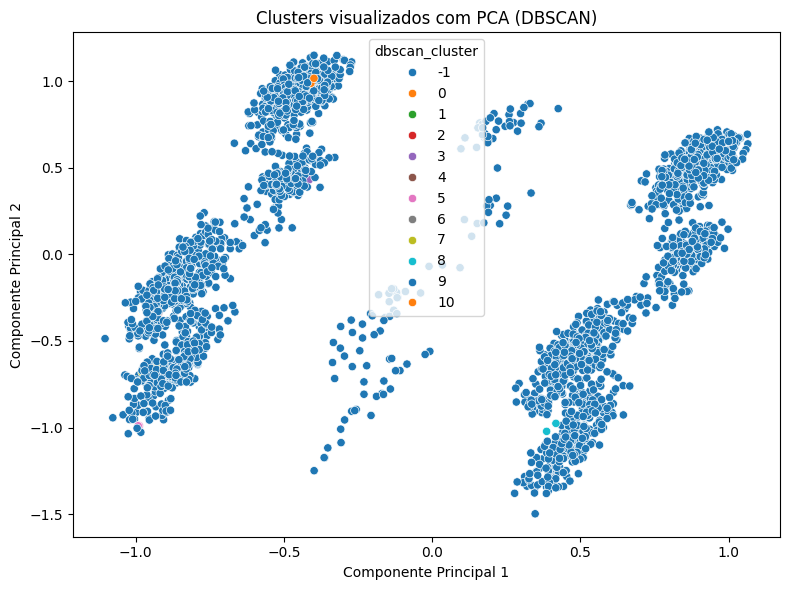

In [12]:
pca = PCA(n_components=2)
components = pca.fit_transform(data_dbscan)

plt.figure(figsize=(8,6))
sns.scatterplot(x=components[:,0], y=components[:,1], hue=data['dbscan_cluster'], palette='tab10')
plt.title('Clusters visualizados com PCA (DBSCAN)')
plt.xlabel('Componente Principal 1')
plt.ylabel('Componente Principal 2')
plt.tight_layout()
plt.show()

## 6. Análise dos Grupos Formados

In [6]:
# Estatísticas descritivas por cluster DBSCAN
for cluster in np.unique(labels):
    print(f'Cluster {cluster}:')
    display(data[data['dbscan_cluster'] == cluster].describe())

Cluster -1:


,Age,Hours_Per_Week,Work_Life_Balance_Score,Social_Isolation_Score,Physical_Health_Shoulder_Pain,Physical_Health_Neck_Pain,Physical_Health_Back_Pain,Physical_Health_Eye_Strain,Physical_Health_Wrist_Pain,dbscan_cluster
count,2877.000000,2877.000000,2877.000000,2877.000000,2877.000000,2877.000000,2877.000000,2877.000000,2877.000000,2877.0
mean,43.700035,49.882169,2.994786,2.714286,0.260341,0.039972,0.543274,0.139381,0.017032,-1.0
std,12.636351,8.890210,1.156244,1.192108,0.438897,0.195928,0.498210,0.346404,0.129412,0.0
min,22.000000,35.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-1.0
25%,33.000000,42.000000,2.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-1.0
50%,44.000000,50.000000,3.000000,3.000000,0.000000,0.000000,1.000000,0.000000,0.000000,-1.0
75%,55.000000,57.000000,4.000000,4.000000,1.000000,0.000000,1.000000,0.000000,0.000000,-1.0
max,65.000000,65.000000,5.000000,5.000000,1.000000,1.000000,1.000000,1.000000,1.000000,-1.0
